# 🧠🤝👐 Semantic & Gesture Representation Extraction and Analysis

This notebook walks you through:

1. **Extracting sentence‑level text-based semantic embeddings** (Dutch BERT 💬).  
2. **Encode iconic gesture strokes with a self‑supervised skeleton model** (👐).
3. **Analyse cosine‑similarity patterns within and across dialogues using semantic and gesture embeddings** (🧠🤝).

The third point is based on the similarity analysis provided in the paper by Ghaleb et al. (2024)‑ICMI: **Learning Co-Speech Gesture Representations in Dialogue through Contrastive Learning: An Intrinsic Evaluation**. It uses cosine similarity between learned embeddings to evaluate the similarity of gestures based on their semantic content and form features. It follows the intrinsic‑evaluation recipe described in the paper, where cosine similarity between learned embeddings correlated positively with the number of shared form features (ρ≈0.31).


## 📑 Notebook overview

1. **⚙️ Environment setup** — install & import libraries

2. **1️⃣ Data & preliminaries** — load annotated gestures & skeletons

3. **2️⃣ Sentence embeddings 💬** — Dutch BERT mean‑pooling

4. **3️⃣ Gesture embeddings 👐** — Multimodal‑X skeleton encoder

5. **4️⃣ Similarity analysis 🔍** — intrinsic evaluation

6. **5️⃣ Dialogue‑level analysis** — speaker ✕ referent effects

7. **📝 Exercise** — try different embedding modalities

## ⚙️ Environment setup

Import common libraries.

In [1]:
import os, sys, pathlib, itertools, json, torch, numpy as np, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import mannwhitneyu

from transformers import AutoTokenizer, AutoModel
import gdown

# Local helpers -------------------------------------------------------
from model.skeleton_speech_models import GSSModel
from data.read_process_poses import load_keypoints_dict
from dialog_utils.prepare_gesture_referents_dataset import get_detailed_gestures
from object_retrieval_pair import manual_implementation_object_retrieval
from statannotations.Annotator import Annotator

sns.set(style='whitegrid', palette='Set2', font_scale=1.1)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [2]:
# I use these commands to make the notebook interactive and automatically reload modified modules)
%load_ext autoreload
%autoreload 2
%matplotlib inline


/opt/anaconda3/envs/test2/lib/python3.10/site-packages/IPython/extensions/autoreload.py:211: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if not hasattr(module, "__file__") or module.__file__ is None:


In [3]:
# set the colors and seaborn style
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='Paired', font_scale=1.2)

## 1️⃣ Data & preliminaries
Load processed keypoints and iconic‑gesture annotations. 

In [4]:
proc_kpts, mir_kpts = load_keypoints_dict()
gestures_df = get_detailed_gestures()
gestures_df = gestures_df[gestures_df['type'] == 'iconic'].reset_index(drop=True)
# Clean referent labels (cf. Ghaleb et al. 2024 §3.2)
suffixes = ['-REP', '-rep', '-WF', '-wf', 'ref', 'REF']
gestures_df['referent_clean'] = gestures_df['referent'].apply(
    lambda x: x if not x.endswith(tuple(suffixes)) else x.split('-')[0])
gestures_df = gestures_df.assign(referent_clean=gestures_df['referent_clean'].str.split('+')).explode('referent_clean')
gestures_df['referent_clean'] = (gestures_df['referent_clean']
                                   .str.strip().str.replace('-', '0').str.replace("'", ''))
gestures_df = gestures_df[gestures_df['referent_clean'] != 'undecided']
gestures_df['processed_referent_target_fribble'] = gestures_df['referent_clean']
print('Iconic gestures loaded:', len(gestures_df))

Iconic gestures loaded: 4637


The data contains metadata about the gestures, including the speaker, referent, and co-occurring transcriped speech. 


In [5]:
gestures_df.head(3)

,pair,turn,round,type,is_gesture,from_ts,to_ts,referent,comment,duration,...,pair_speaker,words,lemmas,pos,lemmas_pos,transcriptions,contain_text,segmentation method,referent_clean,processed_referent_target_fribble
0,pair04,0,1,iconic,gesture,4.093,4.505,main,NaN,0.412,...,pair04_B,zeggen dat hoofdplatform,zeggen dat hoofdplatform,VERB SCONJ NOUN,zeggen#VERB dat#SCONJ hoofdplatform#NOUN,manual,True,manual,main,main
1,pair04,2,1,iconic,gesture,8.459,8.941,09C,NaN,0.482,...,pair04_B,steeksel aan de linkerkant,steeksel aan de linkerkant,NOUN ADP DET NOUN,steeksel#NOUN aan#ADP de#DET linkerkant#NOUN,manual,True,manual,09C,09C
2,pair04,4,1,iconic,gesture,11.781,12.200,09C,NaN,0.419,...,pair04_B,is een rond uitsteeksel,zijn een rond uitsteeksel,AUX DET ADP NOUN,zijn#AUX een#DET rond#ADP uitsteeksel#NOUN,manual,True,manual,09C,09C


## 2️⃣ Sentence embeddings 💬

We first define helper functions to obtain mean‑pooled sentence vectors from Dutch BERT.

In [6]:
def mean_pooling(out, mask):
    tok_emb = out[0]
    mask = mask.unsqueeze(-1).expand(tok_emb.size()).float()
    return (tok_emb * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
def max_pooling(out, mask):
    tok_emb = out[0]
    mask = mask.unsqueeze(-1).expand(tok_emb.size()).float()
    return (tok_emb * mask).max(1)[0]

def load_text_model():
    tok = AutoTokenizer.from_pretrained('GroNLP/bert-base-dutch-cased')
    mdl = AutoModel.from_pretrained('GroNLP/bert-base-dutch-cased', output_hidden_states=True).to(DEVICE).eval()
    return mdl, tok

def encode_sentences(sentences, mdl, tok):
    enc = tok(sentences, padding=True, truncation=True, return_tensors='pt').to(DEVICE)
    with torch.no_grad(): out = mdl(**enc)
    return mean_pooling(out, enc['attention_mask'])

text_model, tokenizer = load_text_model()
print('Dutch BERT loaded')

Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dutch BERT loaded


#### Sentence Embeddings  

Let's first start with loading the Dutch BERT model and defining a function to obtain mean‑pooled sentence vectors.

Then, we demonstrate how to encode two Dutch sentences using the model.


In [7]:
text_model, tokenizer = load_text_model()
TEST = ['zeggen dat hoofdplatform', 'steeksel aan de linkerkant', 'is een rond uitsteeksel']
embs = encode_sentences(TEST, text_model, tokenizer)
print(embs.shape)  # (3, 768)

Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([3, 768])


Cosine similarity matrix:
 [[1.0000004  0.66240704 0.68169314]
 [0.66240704 0.99999994 0.7183249 ]
 [0.68169314 0.7183249  1.0000005 ]]


,zeggen dat hoofdplatform,steeksel aan de linkerkant,is een rond uitsteeksel
zeggen dat hoofdplatform,1.000000,0.662407,0.681693
steeksel aan de linkerkant,0.662407,1.000000,0.718325
is een rond uitsteeksel,0.681693,0.718325,1.000000


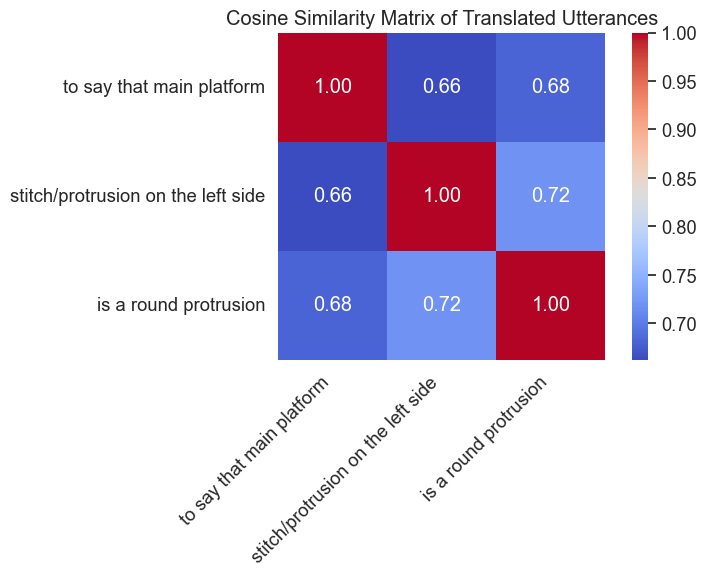

In [8]:
# Cosine similarity between the embeddings
cos_sim = cosine_similarity(embs.cpu().numpy())
print('Cosine similarity matrix:\n', cos_sim)
similarity_df = pd.DataFrame(cos_sim, index=TEST, columns=TEST)
display(similarity_df)
# tranlated utterances: ['to say that main platform', 'stitch/protrusion on the left side', 'is a round protrusion']
translated_similarity_df = similarity_df.copy() 
translated_similarity_df.index = ['to say that main platform', 'stitch/protrusion on the left side', 'is a round protrusion']
translated_similarity_df.columns = ['to say that main platform', 'stitch/protrusion on the left side', 'is a round protrusion']
# display(translated_similarity_df)

# plot the cosine similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(translated_similarity_df, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Cosine Similarity Matrix of Translated Utterances')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
# Encode utterances
embeds = []
for utt in tqdm(gestures_df['processed_utterance'], desc='BERT encoding'):
    sent = '' if pd.isna(utt) else utt.strip()
    emb = encode_sentences([sent], text_model, tokenizer).squeeze(0).cpu().numpy()
    embeds.append(emb)
gestures_df['semantic_embeddings'] = embeds

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


BERT encoding:   0%|          | 0/4637 [00:00<?, ?it/s]

## 3️⃣ Gesture embeddings 👐

We use the `Multimodal-X` encoders from another paper, **I see what you mean: Co-Speech Gestures for Reference Resolution in Multimodal Dialogue** (Ghaleb et al., 2025), to extract gesture embeddings. The models are trained on skeleton and semantic features, and we use it to obtain gesture embeddings.

**NOTE**: we first need to **automaticall download** the model weights from Google Drive. The model is available at [this link](https://drive.google.com/file/d/14lBbWLK53Ct6nOHV84yy2kXTeDh5I0TS/view?usp=sharing).

We will also upload and setup the model weights from the `pretrained_models/multimodal-x` folder.

In [10]:
# ——————— CONFIG TO DOWNLOAD THE MODEL ———————
DRIVE_FILE_ID = "14lBbWLK53Ct6nOHV84yy2kXTeDh5I0TS"
DEST_FOLDER   = pathlib.Path("pretrained_models/multimodal-x")  
FILENAME      = "multimodal-x_skeleton_text.ckpt"  # 
# ——————————————————————

def download_single_file(file_id: str, dest_folder: pathlib.Path, filename: str):
    """Download one Google-Drive file into dest_folder/filename if missing."""
    # 1) make sure folder exists
    dest_folder.mkdir(parents=True, exist_ok=True)
    out_path = dest_folder / filename

    # 2) skip if already there
    if out_path.exists():
        print(f"[✔] {out_path} already exists, skipping download.")
        return
    # 4) download
    url = f"https://drive.google.com/uc?id={file_id}"
    print(f"Downloading to {out_path} …")
    gdown.download(url, str(out_path), quiet=False)
    print("[✔] Download complete.")

# — run it:
download_single_file(DRIVE_FILE_ID, DEST_FOLDER, FILENAME)

def load_pretrained(params):
    path = params['model_weights']
    params = params.copy(); _ = params.pop('model_weights')
    mdl = GSSModel(**params)
    w = torch.load(path, map_location='cpu')
    for k in mdl.state_dict():
        mdl.state_dict()[k].copy_(w['state_dict']['model.'+k])
    return mdl.to(DEVICE).eval()


[✔] pretrained_models/multimodal-x/multimodal-x_skeleton_text.ckpt already exists, skipping download.


In [11]:
MODELS = {
    'multimodal-x': {
        'modalities':['skeleton','semantic'],
        'hidden_dim':256,'cross_modal':True,'attentive_pooling':False,
        'model_weights':'pretrained_models/multimodal-x/multimodal-x_skeleton_text.ckpt'}
}
model_key = 'multimodal-x'
gesture_model = load_pretrained(MODELS[model_key])
gesture_model.eval()
print(f"Model {model_key} pre-trained with modalities: {MODELS[model_key]['modalities']}")

Model multimodal-x pre-trained with modalities: ['skeleton', 'semantic']


Loop through the gesture data and extract the gesture embeddings using the `Multimodal-X` model. 

The following code automatically extract gesture embeddings for all gestures in the dataset. It uses the `GSSModel` class to load the model and extract embeddings for each gesture.

In [12]:
# Extract gesture embeddings ---------------------------------------
gestures_df = manual_implementation_object_retrieval(
    gesture_model, proc_kpts, mir_kpts, 'jointsformer',
    gestures_and_speech_info=gestures_df,
    modalities=['skeleton','semantic'],
    audio_dict={}, model_type='multimodal-x')
gestures_df.rename(columns={'transformer_features':'multimodal-x'}, inplace=True)
print('Embedding vector length:', len(gestures_df['multimodal-x'].iat[0]))

  0%|          | 0/4637 [00:00<?, ?it/s]/opt/anaconda3/envs/test2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2714: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 4637/4637 [07:28<00:00, 10.34it/s]

Embedding vector length: 256


## 4️⃣ Similarity analysis 🔍  Intrinsic Gesture‑Similarity Evaluation


Following Section 5 of the paper, we compare cosine similarity
scores across logically defined *pair types*:

| Pair Type | Same Speaker | Same Referent | Same Dialogue |
|-----------|--------------|---------------|---------------|
| **same-ref & same-speaker** | ✅ | ✅ | ✅ |
| **same-ref & diff-speaker** | ❌ | ✅ | ✅ |
| **diff-ref & same-speaker** | ✅ | ❌ | ✅ |
| **diff-ref & diff-speaker** | ❌ | ❌ | ✅ |
| **Cross‑Dialogue & same-ref** | ❌ | ✅ | ❌ |
| **Cross‑Dialogue & diff-ref** | ❌ | ❌ | ❌ |


**NOTE**: the similarity analysis is based on the concatenated `gesture_embeddings` and `semantic_embeddings` columns in the `gestures_df` DataFrame.

In the code below, the `modality` parameter can be set to either `'gesture'`, `'semantic'`, or `'multimodal'`.



In [13]:
def compute_cosine_similarity(df: pd.DataFrame, model_key: str, modality: str) -> np.ndarray:
    """
    Build a multimodal feature matrix by concatenating model embeddings and semantic embeddings,
    then compute the cosine similarity matrix.
    
    Parameters:
    - df: DataFrame containing gesture data with model embeddings and semantic embeddings.
    - model_key: Column name for the model embeddings in the DataFrame.
    - modality: The modality type: 'gesture', 'semantic', or 'multimodal'.
    """
    vis = np.vstack(df[model_key].to_numpy())
    sem = np.vstack(df['semantic_embeddings'].to_numpy())
    if modality == 'gesture':
        feats = vis
    elif modality == 'semantic':
        feats = sem
    elif modality == 'multimodal':
        feats = np.concatenate([vis, sem], axis=1)
    else:
        raise ValueError('modality must be gesture|semantic|multimodal')
    return cosine_similarity(feats)



def create_pairs_df_for_comparisons(df: pd.DataFrame, sim_mat: np.ndarray) -> pd.DataFrame:
    """
    Build a DataFrame of pairwise similarities with pair_type labels.
    """
    records = []
    for i, j in itertools.combinations(range(len(df)), 2):
        sim = sim_mat[i, j]
        speaker_i, speaker_j = df['pair_speaker'].iat[i], df['pair_speaker'].iat[j]
        referent_i, referent_j = df['processed_referent_target_fribble'].iat[i], df['processed_referent_target_fribble'].iat[j]
        pair_i, pair_j = df['pair'].iat[i], df['pair'].iat[j]

        same_pair = (pair_i == pair_j)
        same_speaker = (speaker_i == speaker_j)
        same_referent = (referent_i == referent_j)

        if same_pair and same_speaker and same_referent:
            pair_type = 'Same P&R&S' # Same pair, same speaker, same referent
        elif same_pair and same_speaker and not same_referent:
            pair_type = 'Same P&S - Diff R' # Same pair, same speaker, different referent
        elif same_pair and not same_speaker and same_referent:
            pair_type = 'Same R &P - diff S' # Same pair, different speaker, same referent
        elif same_pair and not same_speaker and not same_referent:
            pair_type = 'Same P - Diff R&S' # Same pair, different speaker, different referent
        elif not same_pair and same_referent and not same_speaker:
            pair_type = 'Same R - Diff P&S' # Same referent, different pair, different speaker
        elif not same_pair and not same_referent and not same_speaker:
            pair_type = 'Diff P&R&S' # Different pair, different speaker, different referent
        else:
            pair_type = 'Unknown' # Fallback for unexpected cases (should not happen)

        records.append({
            'index_i': i,
            'index_j': j,
            'similarity': sim,
            'pair_type': pair_type
        })
    return pd.DataFrame(records)


def pair_scores(sim_mat: np.ndarray, pairs: list[tuple[int, int]]) -> np.ndarray:
    """
    Return an array of similarity scores for the given index pairs.
    """
    return np.array([sim_mat[i, j] for i, j in pairs])

In [14]:
# Compute similarity matrix
model_key = 'multimodal-x'  # or your model column
sim_matrix = compute_cosine_similarity(gestures_df, model_key, modality='multimodal')
similarities_df = create_pairs_df_for_comparisons(gestures_df, sim_matrix)

## 5️⃣ Speaker-Level Analysis: Speaker & Referent Effects
Following the paper (§5.1), we compute cosine similarity and compare positive vs negative gesture pairs (same vs different referent & speaker).

For this analysis we select the following pair types:

| Pair Type | Same Speaker | Same Referent | Same Dialogue |
|-----------|--------------|---------------|---------------|
| **same-ref & same-speaker** | ✅ | ✅ | ✅ |
| **diff-ref & same-speaker** | ✅ | ❌ | ✅ |

Essentially, we compare gestures (and semantic representations of the co-occuring speech) that refer to the same object and are produced by the same speaker, against gestures that refer to different objects but are produced by the same speaker.

In [20]:
similarities_df

,index_i,index_j,similarity,pair_type
0,0,1,0.710906,Same P&S - Diff R
1,0,2,0.731534,Same P&S - Diff R
2,0,3,0.731534,Same P&S - Diff R
3,0,4,0.745420,Same P - Diff R&S
4,0,5,0.564238,Same P&S - Diff R
...,...,...,...,...
10748561,4633,4635,0.765724,Same P&S - Diff R
10748562,4633,4636,0.765724,Same P&S - Diff R
10748563,4634,4635,1.000000,Same P&S - Diff R
10748564,4634,4636,1.000000,Same P&S - Diff R


/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/2125641744.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot( x='pair_type', y='similarity', data=df, order=order, palette=palette, ax=ax)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Same P&R&S vs. Same P&S - Diff R: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=4.312e+01


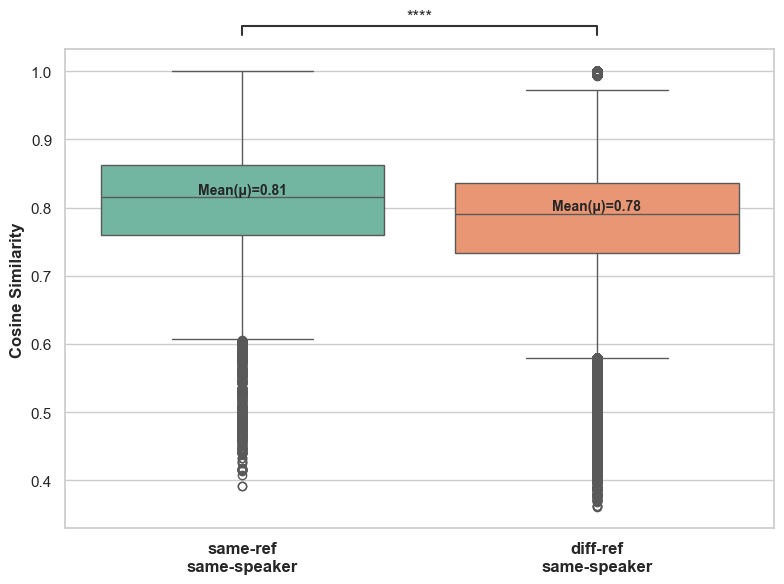

In [15]:
def plot_same_speaker_similarity(similarities_df: pd.DataFrame, subsample: bool) -> None:
    """
    Plot violin distributions of similarity across dialogue pair types,
    with t-test annotations and distinct colors per category.
    """
    order = [
        'Same P&R&S',
        'Same P&S - Diff R',
    ]
    labels = {
        'Same P&R&S': 'same-ref\nsame-speaker',
        'Same P&S - Diff R': 'diff-ref\nsame-speaker',
    }

    df = similarities_df.copy()
    df = df[df['pair_type'].isin(order)]
    df['pair_type'] = pd.Categorical(df['pair_type'], categories=order)

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(8, 6))
    # Use a distinct palette
    palette = sns.color_palette('Set2', n_colors=len(order))
    sns.boxplot( x='pair_type', y='similarity', data=df, order=order, palette=palette, ax=ax)

    comparisons = [
        ('Same P&R&S', 'Same P&S - Diff R'),
    ]
    annotator = Annotator(ax, comparisons, data=df, x='pair_type', y='similarity', order=order)
    annotator.configure(test='t-test_ind', text_format='star', loc='outside', comparisons_correction='Bonferroni', hide_non_significant=True,)
    annotator.apply_and_annotate()

    for i, key in enumerate(order):
        subset = df[df['pair_type'] == key]['similarity']
        mean = subset.mean()
        median = subset.median()
        ax.text(
            i + 0.0, median, f'Mean(μ)={mean:.2f}',
            ha='center', va='bottom', fontsize=10, weight='bold', rotation=0
        )

    ax.set_xlabel('')
    ax.set_ylabel('Cosine Similarity', fontweight='bold', fontsize=12)
    ax.set_xticks(range(len(order)))
    ax.set_xticklabels([labels[key] for key in order], fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.show()


plot_same_speaker_similarity(similarities_df, subsample=True)

## 6️⃣ Dialogue‑level analysis

Replicating the **speaker ✕ referent** effects reported in §5.2


For this analysis we select the following pair types:

| Pair Type | Same Speaker | Same Referent | Same Dialogue |
|-----------|--------------|---------------|---------------|
| **same-ref & same-speaker** | ✅ | ✅ | ✅ |
| **diff-ref & same-speaker** | ✅ | ❌ | ✅ |
|**diff-ref & diff-speaker** | ❌ | ❌ | ✅ |
|**same-ref & diff-speaker** | ❌ | ✅ | ✅ |

The comparison has two parts:
1. **Same speaker**: gestures that refer to the same object and are produced by the same speaker.
2. **Cross speaker**: gestures that refer to the same object but are produced by different speakers in the **same dialogue**.

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Same P&R&S vs. Same P&S - Diff R: t-test independent samples with Bonferroni correction, P_val:9.694e-134 t=2.484e+01
Same R &P - diff S vs. Same P - Diff R&S: t-test independent samples with Bonferroni correction, P_val:3.745e-39 t=1.322e+01
Same P&S - Diff R vs. Same R &P - diff S: t-test independent samples with Bonferroni correction, P_val:1.744e-24 t=-1.036e+01
Same P&S - Diff R vs. Same P - Diff R&S: t-test independent samples with Bonferroni correction, P_val:2.828e-02 t=2.694e+00


/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/1655779171.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pair_type').apply(
/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/1655779171.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='pair_type', y='similarity', data=df, order=order, palette=palette, ax=ax)


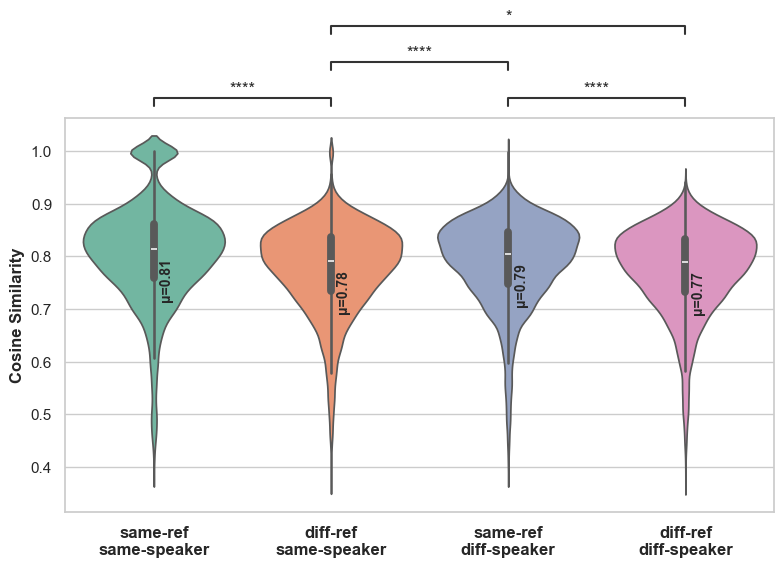

In [16]:
def plot_cross_speaker_similarity(similarities_df: pd.DataFrame, subsample: bool) -> None:
    """
    Plot violin distributions of similarity across dialogue pair types,
    with t-test annotations and distinct colors per category.
    """
    order = [
        'Same P&R&S',
        'Same P&S - Diff R',
        'Same R &P - diff S',
        'Same P - Diff R&S'
    ]
    labels = {
        'Same P&R&S': 'same-ref\nsame-speaker',
        'Same P&S - Diff R': 'diff-ref\nsame-speaker',
        'Same R &P - diff S': 'same-ref\ndiff-speaker',
        'Same P - Diff R&S': 'diff-ref\ndiff-speaker'
    }

    df = similarities_df.copy()
    if subsample:
      # Subsample to the minimum number of pairs
      smallest_size = min(
            df[df['pair_type'] == t].shape[0] for t in order
      )
      # Select a random sample of the minimum size for each type
      df = df.groupby('pair_type').apply(
            lambda x: x.sample(n=smallest_size, random_state=42)
      ).reset_index(drop=True)
    df = df[df['pair_type'].isin(order)]
    df['pair_type'] = pd.Categorical(df['pair_type'], categories=order)

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(8, 6))
    # Use a distinct palette
    palette = sns.color_palette('Set2', n_colors=len(order))
    sns.violinplot(x='pair_type', y='similarity', data=df, order=order, palette=palette, ax=ax)

    comparisons = [
        ('Same P&R&S', 'Same P&S - Diff R'),
        ('Same R &P - diff S', 'Same P - Diff R&S'),
        ('Same P&S - Diff R', 'Same R &P - diff S'),
        ('Same P&S - Diff R', 'Same P - Diff R&S')
    ]
    annotator = Annotator(ax, comparisons, data=df, x='pair_type', y='similarity', order=order)
    annotator.configure(test='t-test_ind', text_format='star', loc='outside', comparisons_correction='Bonferroni', hide_non_significant=True)
    annotator.apply_and_annotate()

    for i, key in enumerate(order):
        subset = df[df['pair_type'] == key]['similarity']
        mean = subset.mean()
        median = subset.median()
        ax.text(
            i + 0.07, median - 0.1, f'μ={mean:.2f}',
            ha='center', va='bottom', fontsize=10, weight='bold', rotation=90
        )

    ax.set_xlabel('')
    ax.set_ylabel('Cosine Similarity', fontweight='bold', fontsize=12)
    ax.set_xticks(range(len(order)))
    ax.set_xticklabels([labels[key] for key in order], fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.show()


plot_cross_speaker_similarity(similarities_df, subsample=True)

## 7️⃣ Cross Dialouges Analysis
Replicating the **Referent vs. Interaction Driven Similarity** where we compare the similarity of gestures across dialogues, as described in §5.2.2 of the paper.

Specificall, we use the following pair types:
| Pair Type | Same Speaker | Same Referent | Same Dialogue |
|-----------|--------------|---------------|---------------|
| **same-ref & diff-speaker** | ❌ | ✅ | ✅ |
| **diff-ref & diff-speaker** | ❌ | ❌ | ✅ |
|**Cross‑Dialogue & same-ref** | ❌ | ✅ | ❌ |
|**Cross‑Dialogue & diff-ref** | ❌ | ❌ | ❌ |

/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/897590085.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/897590085.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Same R &P - diff S vs. Same R - Diff P&S: t-test independent samples with Bonferroni correction, P_val:6.161e-66 t=1.722e+01
Same P - Diff R&S vs. Diff P&R&S: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=9.453e+01
Same R - Diff P&S vs. Same P - Diff R&S: t-test independent samples with Bonferroni correction, P_val:1.021e-11 t=6.960e+00


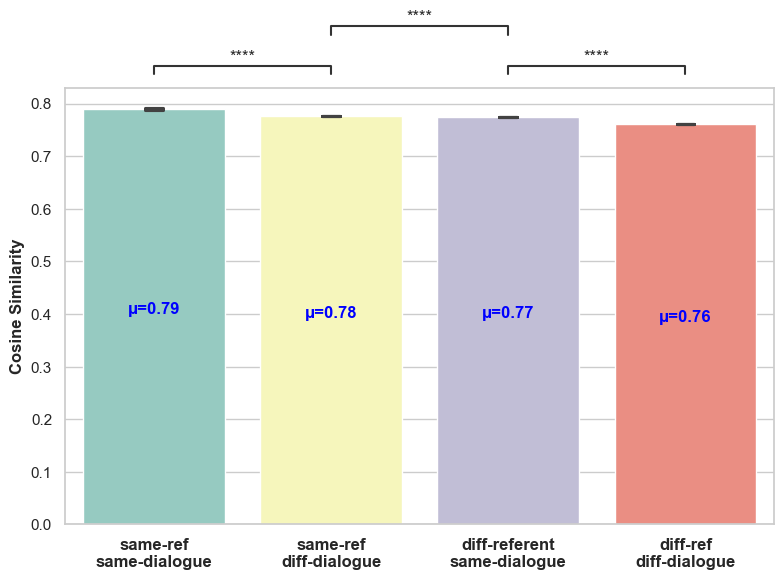

In [17]:
def plot_cross_dialogue_similarity(similarities_df: pd.DataFrame, subsample: bool) -> None:
    """
    Plot bar distributions of similarity for cross-speakers and cross-dialogue pair types,
    with t-test annotations and mean labels.
    """
    cross_types = [
        'Same R &P - diff S',
        'Same R - Diff P&S',
        'Same P - Diff R&S',
        'Diff P&R&S'
    ]
    if subsample:
    # subsample to the minimum number of pairs
        smalles_size = min(
            similarities_df[similarities_df['pair_type'] == t].shape[0] for t in cross_types
        )
        # select a random sample of the minimum size for each type
        similarities_df = similarities_df.groupby('pair_type').apply(
            lambda x: x.sample(n=smalles_size, random_state=42)
        ).reset_index(drop=True)
    
    
    # Define labels for the x-axis
    labels = {
        'Same R &P - diff S': 'same-ref\nsame-dialogue',
        'Same R - Diff P&S': 'same-ref\ndiff-dialogue',
        'Same P - Diff R&S': 'diff-referent\nsame-dialogue',
        'Diff P&R&S': 'diff-ref\ndiff-dialogue'
    }

    df = similarities_df.copy()
    df = df[df['pair_type'].isin(cross_types)]
    df['pair_type'] = pd.Categorical(df['pair_type'], categories=cross_types)

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(8, 6))
    palette = sns.color_palette('Set3', n_colors=len(cross_types))
    sns.barplot(
        x='pair_type', y='similarity', data=df,
        order=cross_types, palette=palette, ax=ax,
        ci=95,  # Show standard deviation as error bars,
        capsize=0.1,  # Add caps to error bars
        # errorbar='se',  # Use standard error for error bars
    )

    comparisons = [
        ('Same R &P - diff S', 'Same R - Diff P&S'),
        ('Same P - Diff R&S', 'Diff P&R&S'),
        ('Same R - Diff P&S', 'Same P - Diff R&S')
    ]
    annotator = Annotator(ax, comparisons, data=df, x='pair_type', y='similarity', order=cross_types)
    annotator.configure( test='t-test_ind', text_format='star', loc='outside', comparisons_correction='Bonferroni', hide_non_significant=True,)
    annotator.apply_and_annotate()

    for i, key in enumerate(cross_types):
        mean_val = df[df['pair_type'] == key]['similarity'].mean()
        ax.text(
            i, mean_val / 2, f'μ={mean_val:.2f}',
            ha='center', va='bottom', fontsize=12, weight='bold', color='blue'
        )

    ax.set_xlabel('')
    ax.set_ylabel('Cosine Similarity', fontweight='bold', fontsize=12)
    ax.set_xticks(range(len(cross_types)))
    ax.set_xticklabels([labels[key] for key in cross_types], fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.show()
    
plot_cross_dialogue_similarity(similarities_df, subsample=False)

## 📝 Exercise — compare modalities & models
Set `MODALITY` below, then run to regenerate intrinsic similarity plots.

* **MODALITY**: `'gesture'`, `'semantic'`, or `'multimodal'`.

/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/2125641744.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot( x='pair_type', y='similarity', data=df, order=order, palette=palette, ax=ax)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Same P&R&S vs. Same P&S - Diff R: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=7.698e+01


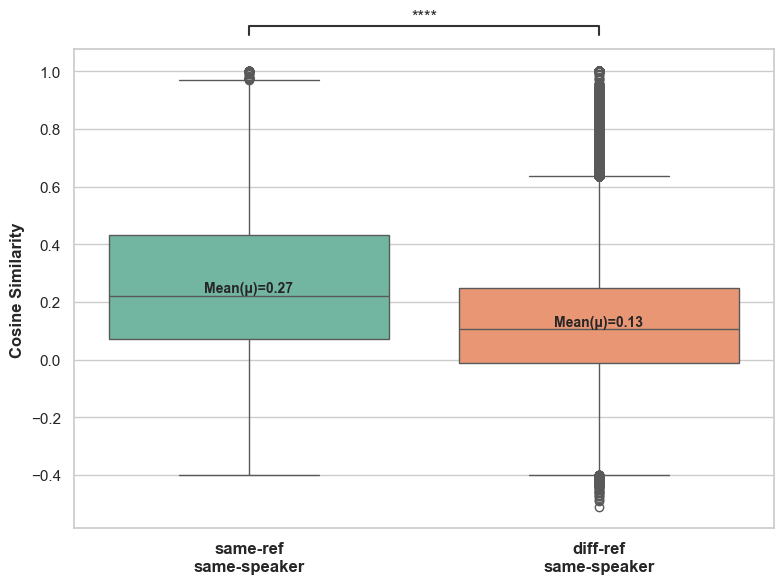

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Same P&R&S vs. Same P&S - Diff R: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=4.113e+01
Same R &P - diff S vs. Same P - Diff R&S: t-test independent samples with Bonferroni correction, P_val:1.506e-62 t=1.683e+01
Same P&S - Diff R vs. Same R &P - diff S: t-test independent samples with Bonferroni correction, P_val:9.410e-63 t=1.686e+01
Same P&S - Diff R vs. Same P - Diff R&S: t-test independent samples with Bonferroni correction, P_val:4.477e-219 t=3.201e+01


/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/1655779171.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pair_type').apply(
/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/1655779171.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='pair_type', y='similarity', data=df, order=order, palette=palette, ax=ax)


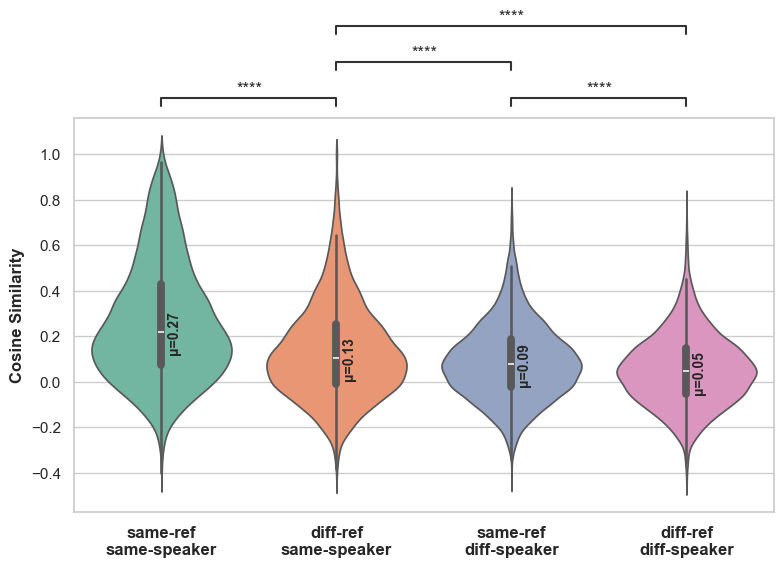

/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/897590085.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/897590085.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Same R &P - diff S vs. Same R - Diff P&S: t-test independent samples with Bonferroni correction, P_val:6.181e-09 t=5.993e+00
Same P - Diff R&S vs. Diff P&R&S: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=4.055e+01
Same R - Diff P&S vs. Same P - Diff R&S: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=6.049e+01


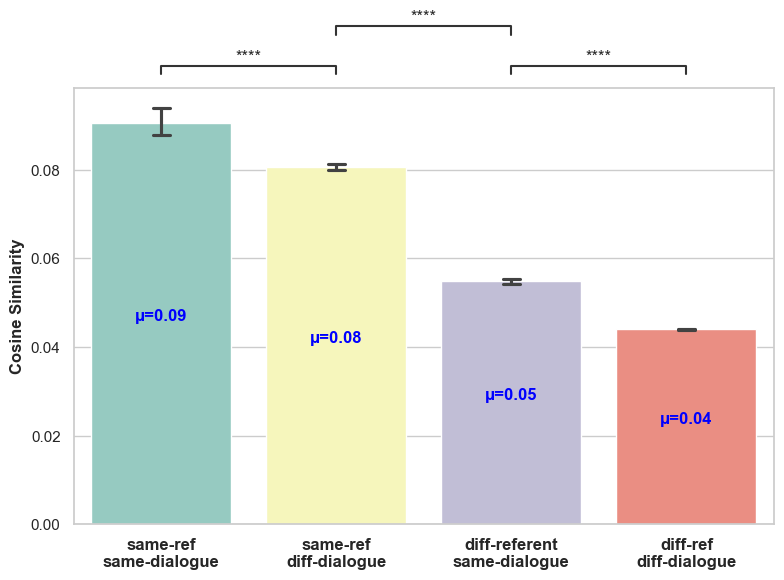

In [18]:
### ↘️ edit here and re‑run ################################################
MODEL_KEY = 'multimodal-x'   # e.g. 'multimodal-x'
MODALITY  = 'gesture'     # 'gesture' | 'semantic' | 'multimodal'
########################################################################

sim_mat = compute_cosine_similarity(gestures_df, MODEL_KEY, modality=MODALITY)
similarities_df = create_pairs_df_for_comparisons(gestures_df, sim_mat)
# Plot the similarity distributions
plot_same_speaker_similarity(similarities_df, subsample=True)
plot_cross_speaker_similarity(similarities_df, subsample=True)
plot_cross_dialogue_similarity(similarities_df, subsample=False)

## 8️⃣ Conclusion ✨

We reproduced the intrinsic evaluation workflow showing that cosine similarity of contrastively‑learned gesture embeddings, which rises with the number of shared form features. It tracks features related to the semantic content of the gestures, speaker style, and interaction content. 

More importantly, we compute **multimodal similarity by concatenating gesture and semantic embeddings**, which can be used to analyse the interaction between gesture and speech in dialogue.


/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/2125641744.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot( x='pair_type', y='similarity', data=df, order=order, palette=palette, ax=ax)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Same P&R&S vs. Same P&S - Diff R: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=4.229e+01


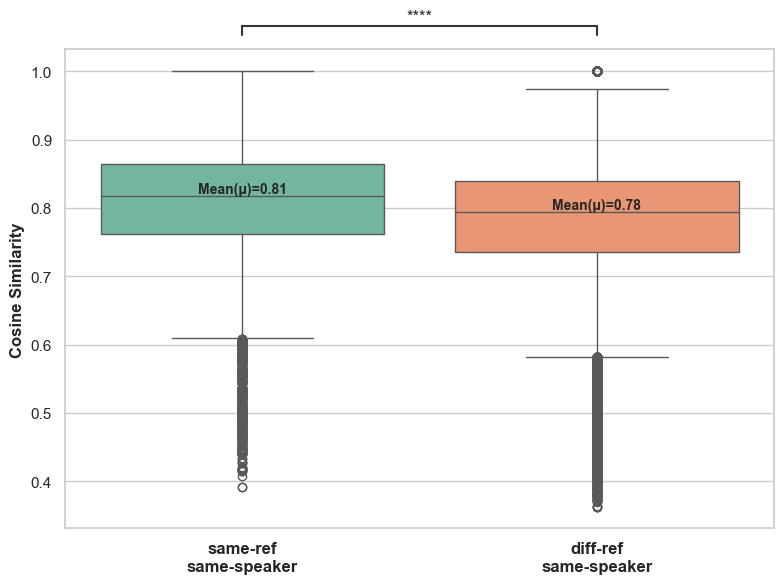

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Same P&R&S vs. Same P&S - Diff R: t-test independent samples with Bonferroni correction, P_val:5.474e-129 t=2.439e+01
Same R &P - diff S vs. Same P - Diff R&S: t-test independent samples with Bonferroni correction, P_val:2.612e-38 t=1.307e+01
Same P&S - Diff R vs. Same R &P - diff S: t-test independent samples with Bonferroni correction, P_val:2.978e-25 t=-1.053e+01


/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/1655779171.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pair_type').apply(
/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/1655779171.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='pair_type', y='similarity', data=df, order=order, palette=palette, ax=ax)


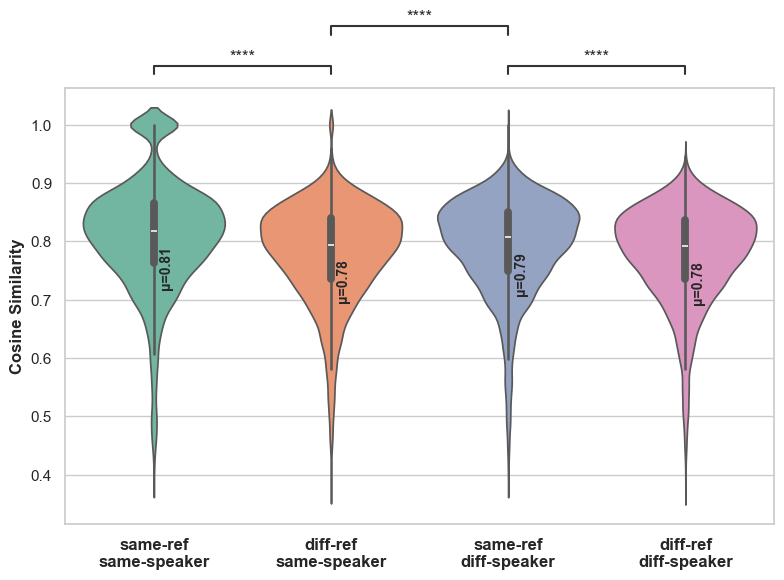

/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/897590085.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_36552/897590085.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Same R &P - diff S vs. Same R - Diff P&S: t-test independent samples with Bonferroni correction, P_val:1.848e-65 t=1.716e+01
Same P - Diff R&S vs. Diff P&R&S: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=9.424e+01
Same R - Diff P&S vs. Same P - Diff R&S: t-test independent samples with Bonferroni correction, P_val:4.316e-10 t=6.412e+00


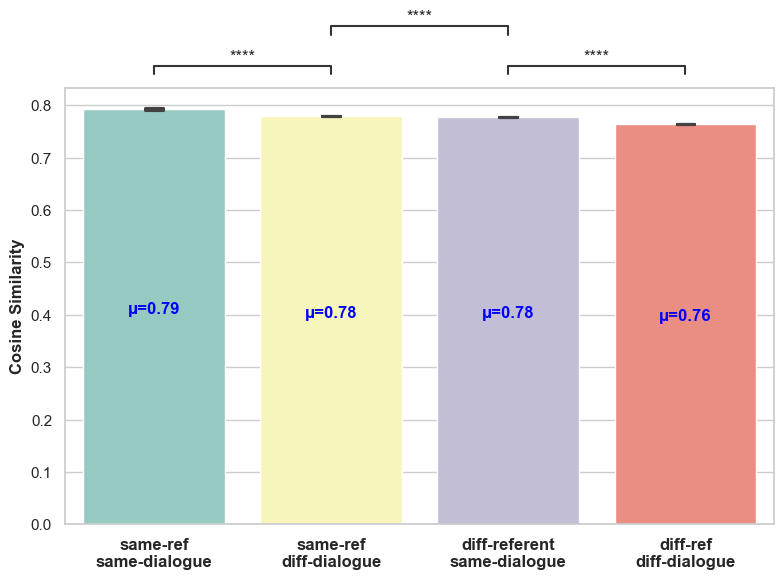

In [19]:
### ↘️ edit here and re‑run ################################################
MODEL_KEY = 'multimodal-x'   # e.g. 'multimodal-x'
MODALITY  = 'semantic'     # 'gesture' | 'semantic' | 'multimodal'
########################################################################

sim_mat = compute_cosine_similarity(gestures_df, MODEL_KEY, modality=MODALITY)
similarities_df = create_pairs_df_for_comparisons(gestures_df, sim_mat)
# Plot the similarity distributions
plot_same_speaker_similarity(similarities_df, subsample=True)
plot_cross_speaker_similarity(similarities_df, subsample=True)
plot_cross_dialogue_similarity(similarities_df, subsample=False)